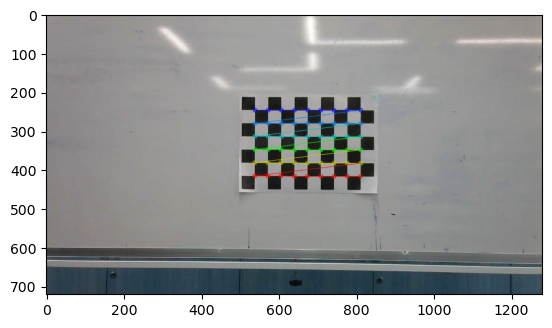

In [21]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import glob

CHESSBOARD_CORNER_NUM_X = 9
CHESSBOARD_CORNER_NUM_Y = 6
CAMERA_PARAMETERS_OUTPUT_FILE = "cam1.yaml"

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((CHESSBOARD_CORNER_NUM_X*CHESSBOARD_CORNER_NUM_Y,3), np.float32)
objp[:,:2] = np.mgrid[0:CHESSBOARD_CORNER_NUM_X,0:CHESSBOARD_CORNER_NUM_Y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('./chessboarding/*.jpg')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), corners2, ret)
        plt.imshow(img);
    else:
        print('Failed to find a chessboard in {}'.format(fname))

(720, 1280, 3)


In [28]:
print ("Calibrating camera .... Please wait...")
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print("Camera matrix is \n", mtx, "\n And is stored in calibration.yaml file along with distortion coefficients : \n", dist)
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )
# data = {'camera_matrix': np.asarray(mtx).tolist(), 'dist_coeff': np.asarray(dist).tolist()}
# with open(CAMERA_PARAMETERS_OUTPUT_FILE, "w") as f:
#     yaml.dump(data, f)


Camera matrix:
 [[2.71244173e+03 0.00000000e+00 5.84464502e+02]
 [0.00000000e+00 2.69999388e+03 3.24380968e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Parameters:
 [[-2.69632867e-01  1.47517078e+01  1.86942704e-02  2.31654394e-03
  -1.74772058e+02]]


In [23]:
print(img.shape)
x_mm = 1280 /50 * 40
y_mm = 720 / 50 *40
focalx = 1 * 3.58 / x_mm
focaly = 1 * 2.02 / y_mm
print(focalx)
print(focaly)
print(40 / 50* mtx[0][0])
print(40 / 50* mtx[1][1])

(720, 1280, 3)
0.00349609375
0.0035069444444444445
2169.953382889554
2159.99510275565


In [24]:

def pix_to_mm(fx, fy, width, height):
    ''' convert focal length from pixel to mm'''
    SENSOR_SIZE = np.array([3.58, 2.02])
    # Calculate the size of each pixel in millimeters
    pixel_size_mm = SENSOR_SIZE/ np.array([width, height])
    
    # Calculate the focal lengths in millimeters
    fx_mm = fx * pixel_size_mm[0]
    fy_mm = fy * pixel_size_mm[1]
    
    
    # Print the results
    print("The focal length in the x direction is", fx_mm, "mm")
    print("The focal length in the y direction is", fy_mm, "mm")

In [25]:
fx = mtx[0][0]
fy = mtx[1][1]
width = img.shape[1]
height = img.shape[0]
pix_to_mm(fx, fy, width, height)

The focal length in the x direction is 7.5863604597115275 mm
The focal length in the y direction is 7.574982825636132 mm


Text(0.5, 1.0, 'undistorted')

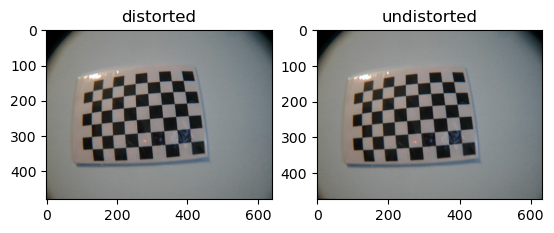

In [26]:
#undistort an image
img = cv.imread('./cam2_images/11.jpg')
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
dst = cv.undistort(img, mtx, dist, None, newcameramtx)
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv.imwrite('undistort.png', dst)
plt.subplot(121)
plt.imshow(img)
plt.title('distorted')
plt.subplot(122)
plt.imshow(dst)
plt.title('undistorted')


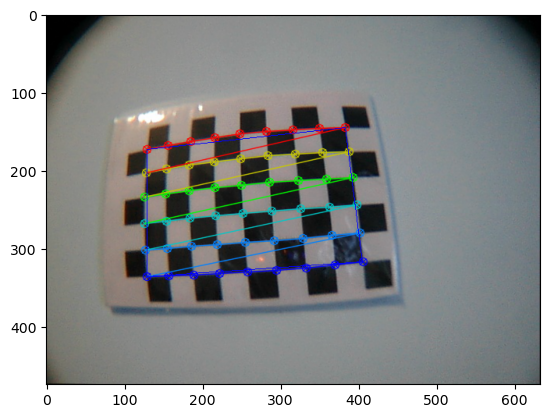

In [27]:
#check distortion of the iamge to see if it is undistorted
undistort = cv.imread('undistort.png')
undistort_gray = cv.cvtColor(undistort, cv.COLOR_BGR2GRAY)

# Find the chess board corners
ret_undistort, corners_undistort = cv.findChessboardCorners(undistort_gray, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)

corners_undistort = cv.cornerSubPix(undistort_gray,corners_undistort, (11,11), (-1,-1), criteria)
# Draw and display the corners
cv.drawChessboardCorners(undistort, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), corners_undistort, ret_undistort)
# Draw 4 lines
cv.line(undistort, tuple(map(int, corners_undistort[0, 0])), tuple(map(int, corners_undistort[45, 0])), (0, 0, 255), 1)
cv.line(undistort, tuple(map(int, corners_undistort[8, 0])), tuple(map(int, corners_undistort[53, 0])), (0, 0, 255), 1)
cv.line(undistort, tuple(map(int, corners_undistort[0, 0])), tuple(map(int, corners_undistort[8, 0])), (0, 0, 255), 1)
cv.line(undistort, tuple(map(int, corners_undistort[45, 0])), tuple(map(int, corners_undistort[53, 0])), (0, 0, 255), 1)     
plt.imshow(undistort)